In [6]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd

In [7]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res


# Set experiment(s) to analyze


In [12]:
exp_ids=['2018_04_16_15_38_18_780 Ramsey tgap scan sitting between sites'
        ]
assorted={}
assorted['qdp_class']=[]
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['qdp_class'].append(container['qdp_class'])
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Coudn't find processed qdp. Loading and saving


IOError: Unable to create file (Unable to open file: name = 'd:/data/2018_04_16/2018_04_16_15_38_18_780 ramsey tgap scan sitting between sites/results.hdf5', errno = 17, error message = 'file exists', flags = 15, o_flags = 502)

# Experiment-wise analysis

In [26]:
assorted['exp_ids']

['2018_04_16_15_17_15_780 Ramsey tgap scan sitting between sites']

<IPython.core.display.Javascript object>


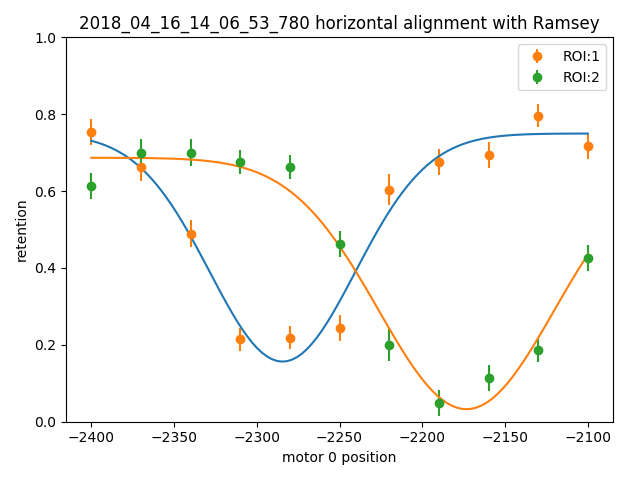

amplitude: -0.593379605018 , x0: -2284.44523319, sigma:62.2082199015 
amplitude: -0.3 , x0: -2330.0, sigma:1.0 
amplitude: -0.654071784518 , x0: -2173.3175786, sigma:75.0326426424 
amplitude: -0.3 , x0: -2330.0, sigma:1.0 


In [16]:
assorted_roi3freqs=[]
assorted_roi2freqs=[]
assorted_roi3perr=[]
assorted_roi2perr=[]
i=0
exp_id=assorted['exp_ids'][i]
q=assorted['qdp_class'][i]
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()

colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fit_guesses=[-0.5, -2180, 100 , 0.8]
fit_guesses2=[-0.3, -2330, 1, 0.8]
#roi_dependency=[0,0,0,0,0]
fitted_parameters=[]
for roi in [1,2]:
    error=0
    data = []
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
    #guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
    try:
        fit,pcov = curve_fit(gaussian,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
       #fit2,pcov2 = curve_fit(gaussian,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
    except RuntimeError:
        error=1
    if error is not 1:
        print "amplitude: {} , x0: {}, sigma:{} ".format(fit[0],fit[1],fit[2])
        print "amplitude: {} , x0: {}, sigma:{} ".format(fit2[0],fit2[1],fit2[2])
        
        xarray=np.linspace(np.min(data),np.max(data),100)
        yfit=gaussian(xarray, fit[0], fit[1], fit[2], fit[3])
        plt.plot(xarray,yfit)
       # yfit2=gaussian(xarray, fit2[0], fit2[1], fit2[2], fit2[3])
        #plt.plot(xarray,yfit,label="mj=5/2", color=colors[0])
        #plt.plot(xarray,yfit2,label="mj=3/2", color=colors[1])

#         if roi==3:
#             assorted_roi3freqs.append(fit[2])
#             assorted_roi3perr.append(np.sqrt(pcov[2][2]))
#         elif roi==2:
#             assorted_roi2freqs.append(fit[2])
#             assorted_roi2perr.append(np.sqrt(pcov[2][2]))

plt.show()
ax.set_title(exp_id)
ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')
ax.legend()
plt.tight_layout()
plt.savefig('{}.pdf'.format(exp_id))

In [21]:
(2284.4+2175)/2

2229.7

<IPython.core.display.Javascript object>


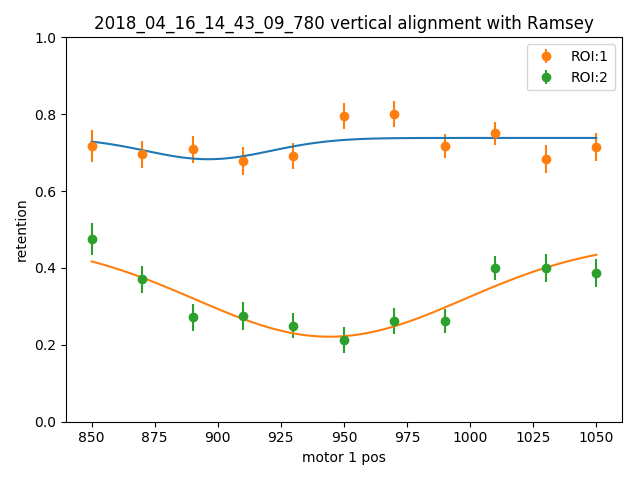

amplitude: -0.0553562133016 , x0: 896.28770205, sigma:35.0069702339 
amplitude: -0.3 , x0: -2330.0, sigma:1.0 
amplitude: -0.247794789823 , x0: 944.28040165, sigma:75.4295555214 
amplitude: -0.3 , x0: -2330.0, sigma:1.0 


In [20]:
assorted_roi3freqs=[]
assorted_roi2freqs=[]
assorted_roi3perr=[]
assorted_roi2perr=[]
i=0
exp_id=assorted['exp_ids'][i]
q=assorted['qdp_class'][i]
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()

colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fit_guesses=[-0.5, 950, 100 , 0.8]
fit_guesses2=[-0.3, -2330, 1, 0.8]
#roi_dependency=[0,0,0,0,0]
fitted_parameters=[]
for roi in [1,2]:
    error=0
    data = []
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
    #guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
    try:
        fit,pcov = curve_fit(gaussian,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
       #fit2,pcov2 = curve_fit(gaussian,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
    except RuntimeError:
        error=1
    if error is not 1:
        print "amplitude: {} , x0: {}, sigma:{} ".format(fit[0],fit[1],fit[2])
        print "amplitude: {} , x0: {}, sigma:{} ".format(fit2[0],fit2[1],fit2[2])
        
        xarray=np.linspace(np.min(data),np.max(data),100)
        yfit=gaussian(xarray, fit[0], fit[1], fit[2], fit[3])
        plt.plot(xarray,yfit)
       # yfit2=gaussian(xarray, fit2[0], fit2[1], fit2[2], fit2[3])
        #plt.plot(xarray,yfit,label="mj=5/2", color=colors[0])
        #plt.plot(xarray,yfit2,label="mj=3/2", color=colors[1])

#         if roi==3:
#             assorted_roi3freqs.append(fit[2])
#             assorted_roi3perr.append(np.sqrt(pcov[2][2]))
#         elif roi==2:
#             assorted_roi2freqs.append(fit[2])
#             assorted_roi2perr.append(np.sqrt(pcov[2][2]))

plt.show()
ax.set_title(exp_id)
ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')
ax.legend()
plt.tight_layout()
plt.savefig('{}.pdf'.format(exp_id))

<IPython.core.display.Javascript object>


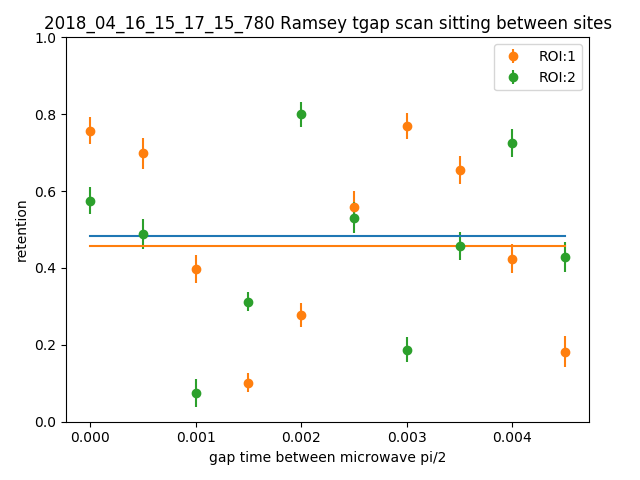

amplitude: -0.5 , x0: 950.0, sigma:100.0 
amplitude: -0.3 , x0: -2330.0, sigma:1.0 
amplitude: -0.5 , x0: 950.0, sigma:100.0 
amplitude: -0.3 , x0: -2330.0, sigma:1.0 


In [27]:
assorted_roi3freqs=[]
assorted_roi2freqs=[]
assorted_roi3perr=[]
assorted_roi2perr=[]
i=0
exp_id=assorted['exp_ids'][i]
q=assorted['qdp_class'][i]
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()

colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fit_guesses=[-0.5, 950, 100 , 0.8]
fit_guesses2=[-0.3, -2330, 1, 0.8]
#roi_dependency=[0,0,0,0,0]
fitted_parameters=[]
for roi in [1,2]:
    error=0
    data = []
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
    #guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
    try:
        fit,pcov = curve_fit(gaussian,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
       #fit2,pcov2 = curve_fit(gaussian,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
    except RuntimeError:
        error=1
    if error is not 1:
        print "amplitude: {} , x0: {}, sigma:{} ".format(fit[0],fit[1],fit[2])
        print "amplitude: {} , x0: {}, sigma:{} ".format(fit2[0],fit2[1],fit2[2])
        
        xarray=np.linspace(np.min(data),np.max(data),100)
        yfit=gaussian(xarray, fit[0], fit[1], fit[2], fit[3])
        plt.plot(xarray,yfit)
       # yfit2=gaussian(xarray, fit2[0], fit2[1], fit2[2], fit2[3])
        #plt.plot(xarray,yfit,label="mj=5/2", color=colors[0])
        #plt.plot(xarray,yfit2,label="mj=3/2", color=colors[1])

#         if roi==3:
#             assorted_roi3freqs.append(fit[2])
#             assorted_roi3perr.append(np.sqrt(pcov[2][2]))
#         elif roi==2:
#             assorted_roi2freqs.append(fit[2])
#             assorted_roi2perr.append(np.sqrt(pcov[2][2]))

plt.show()
ax.set_title(exp_id)
ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')
ax.legend()
plt.tight_layout()
plt.savefig('{}.pdf'.format(exp_id))